<center><h1>Modelling</h1></center> <br>
The purpose of this notebook is to utilize the merged seasons data from <a href='https://github.com/vaastav/Fantasy-Premier-League/'>vaastav's public github repository</a> which regularly accesses and updates from the FPL API storing the data in csv files.

We will begin by merging the gameweek-by-gameweek data from previous season to the last season (2022-23). Once this is completed, we will engineer features that may be beneficial to predicting the points earned in a gameweek. We will then move on to comparing different types of regression models with hyperparameter tuning and selecting the model with the best RMSE score.

RMSE is the average difference between predicted values and actual values, we will be attempting to optimize for a low RMSE score.

Below is a breakdown of the steps to be taken:

1. [Data Merging and Feature Selection](#dmfs)<br><br>
2. [Feature Engineering and Noise Reduction](#fenr) <br><br>
3. [Feature Correlation Map](#fcm)<br><br>
4. [Modelling](#m) <br>
    a. [Linear Regression](#lr) <br>
    b. [Lasso Regression](#lasso) <br>
    c. [Ridge Regression](#ridge) <br>
    d. [Random Forest Regressor](#rfr) <br>
    e. [XGB Regressor](#xgb) <br><br>
5. [Model Comparison](#mc) <br>

<a id="dmfs"><h1>Data Merging and Feature Selection</h1></a>

In this section we will import the necessary libraries and reading in the previous season data (2016-17 to 2021-22). We will be taking a look at the data and seeing if there is any data cleaning that may be required and then selecting features for modelling. 

We will repeat this process with the previous season (2022-23) and merge this to create a combined dataframe containing all historical data.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

cleaned_seasons = pd.read_csv('../data/cleaned_merged_seasons.csv', index_col=0)
cleaned_seasons.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98402 entries, 0 to 98401
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           98402 non-null  object 
 1   name               98402 non-null  object 
 2   position           98402 non-null  object 
 3   team_x             48930 non-null  object 
 4   assists            98402 non-null  int64  
 5   bonus              98402 non-null  int64  
 6   bps                98402 non-null  int64  
 7   clean_sheets       98402 non-null  int64  
 8   creativity         98402 non-null  float64
 9   element            98402 non-null  int64  
 10  fixture            98402 non-null  int64  
 11  goals_conceded     98402 non-null  int64  
 12  goals_scored       98402 non-null  int64  
 13  ict_index          98402 non-null  float64
 14  influence          98402 non-null  float64
 15  kickoff_time       98402 non-null  object 
 16  minutes            984

C:\Users\Farhan Kassam\AppData\Local\Temp\ipykernel_11104\1541133532.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_seasons = pd.read_csv('../data/cleaned_merged_seasons.csv', index_col=0)


In [2]:
cleaned_seasons.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2016-08-15T19:00:00Z,0,4,Chelsea,0,0,0,0,1,0,14023,1.0,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,3,0,0,0.9,8.2,2016-08-13T14:00:00Z,15,17,Spurs,0,0,0,0,1,0,13918,1.0,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,8,3,0,3.0,2.2,2016-08-14T15:00:00Z,60,9,Liverpool,0,0,0,0,1,0,163170,4.0,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,7,0,0,0.0,0.0,2016-08-13T14:00:00Z,0,13,Southampton,0,0,0,0,1,0,1051,1.0,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,6,1,0,0.3,2.0,2016-08-13T14:00:00Z,69,14,Stoke,0,0,0,0,1,0,2723,1.0,1.0,0.0,1,0,0,0,45,True,1,1


In [3]:
# Checking if the empty team name values are from seasons 2016-17 to 2019-20

cleaned_seasons.loc[cleaned_seasons['team_x'].isnull() == True,].equals\
(cleaned_seasons.loc[cleaned_seasons['season_x'] <= '2019-20',])

True

Since I've decided not to include the team of a player as a contributing factor to their FPL score I will not be attempting to fill the null values and continue to reduce the shape of the dataframe for relevant columns. 

Although the team name is significant when picking a team since there cannot be more than 3 players from the same team on a Fantasy team, this is only significant in our testing sets which we will pick from the 22/23 season data.

In [4]:
season_slice = cleaned_seasons[['season_x', 'name', 'position', 'GW', 'value', 'minutes', 'influence', 'creativity', 'threat', 'ict_index', 'total_points']]
season_slice.head()

,season_x,name,position,GW,value,minutes,influence,creativity,threat,ict_index,total_points
0,2016-17,Aaron Cresswell,DEF,1,55,0,0.0,0.0,0.0,0.0,0
1,2016-17,Aaron Lennon,MID,1,60,15,8.2,0.3,0.0,0.9,1
2,2016-17,Aaron Ramsey,MID,1,80,60,2.2,4.9,23.0,3.0,2
3,2016-17,Abdoulaye Doucouré,MID,1,50,0,0.0,0.0,0.0,0.0,0
4,2016-17,Adam Forshaw,MID,1,45,69,2.0,1.3,0.0,0.3,1


In [5]:
last_season = pd.read_csv('../data/merged_gw.csv')
last_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26505 entries, 0 to 26504
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   name                        26505 non-null  object 
 1   position                    26505 non-null  object 
 2   team                        26505 non-null  object 
 3   xP                          26505 non-null  float64
 4   assists                     26505 non-null  int64  
 5   bonus                       26505 non-null  int64  
 6   bps                         26505 non-null  int64  
 7   clean_sheets                26505 non-null  int64  
 8   creativity                  26505 non-null  float64
 9   element                     26505 non-null  int64  
 10  expected_assists            26505 non-null  float64
 11  expected_goal_involvements  26505 non-null  float64
 12  expected_goals              26505 non-null  float64
 13  expected_goals_conceded     265

In [6]:
last_season['season_x'] = '2022-23'

In [7]:
subset_last_season = last_season[['season_x', 'name', 'position', 'GW', 'value', 'minutes', 'influence', 'creativity', 'threat', 'ict_index', 'total_points']]
subset_last_season.head()

,season_x,name,position,GW,value,minutes,influence,creativity,threat,ict_index,total_points
0,2022-23,Nathan Redmond,MID,1,55,1,0.0,0.0,0.0,0.0,1
1,2022-23,Junior Stanislas,MID,1,50,1,0.0,0.0,0.0,0.0,1
2,2022-23,Armando Broja,FWD,1,55,15,5.2,0.3,19.0,2.5,1
3,2022-23,Fabian Schär,DEF,1,45,90,66.0,14.6,25.0,10.6,15
4,2022-23,Jonny Evans,DEF,1,45,90,14.0,1.3,0.0,1.5,1


In [8]:
all_season = pd.concat([season_slice, subset_last_season], ignore_index=True)
all_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124907 entries, 0 to 124906
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   season_x      124907 non-null  object 
 1   name          124907 non-null  object 
 2   position      124907 non-null  object 
 3   GW            124907 non-null  int64  
 4   value         124907 non-null  int64  
 5   minutes       124907 non-null  int64  
 6   influence     124907 non-null  float64
 7   creativity    124907 non-null  float64
 8   threat        124907 non-null  float64
 9   ict_index     124907 non-null  float64
 10  total_points  124907 non-null  int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 10.5+ MB


<a id="fenr"><h1>Feature Engineering and Noise Reduction</h1></a>

Now we have data from 2016-17 to 2022-23 in our dataframe. Since the ict statistics are populated on a per game basis, we will create a lagged feature for all of our attributes for the previous match, previous 3 matches and previous 5 matches averages as well as rolling sums for all the features.

In [9]:
all_season.columns[5:10]

Index(['minutes', 'influence', 'creativity', 'threat', 'ict_index'], dtype='object')

In [10]:
to_lag = all_season.columns[5:10]

for col in to_lag:
    for lag in [1,3,5, 'all']:
        lagged = 'last_' + str(lag)+ '_' + col
        if lag == 'all':
            all_season[lagged] = all_season.sort_values('GW').groupby(['name', 'season_x'], group_keys = False)[col].apply(lambda x: x.cumsum() - x)
        else:
            all_season[lagged] = all_season.sort_values('GW').groupby(['name', 'season_x'], group_keys=False)[col].apply(lambda x: (x.rolling(min_periods=1, window=lag+1).sum() - x)/lag)

In [11]:
all_season.head()

,season_x,name,position,GW,value,minutes,influence,creativity,threat,ict_index,total_points,last_1_minutes,last_3_minutes,last_5_minutes,last_all_minutes,last_1_influence,last_3_influence,last_5_influence,last_all_influence,last_1_creativity,last_3_creativity,last_5_creativity,last_all_creativity,last_1_threat,last_3_threat,last_5_threat,last_all_threat,last_1_ict_index,last_3_ict_index,last_5_ict_index,last_all_ict_index
0,2016-17,Aaron Cresswell,DEF,1,55,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-17,Aaron Lennon,MID,1,60,15,8.2,0.3,0.0,0.9,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-17,Aaron Ramsey,MID,1,80,60,2.2,4.9,23.0,3.0,2,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-17,Abdoulaye Doucouré,MID,1,50,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-17,Adam Forshaw,MID,1,45,69,2.0,1.3,0.0,0.3,1,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since the largest lag is previous 5 matches, the first 5 gameweeks of each season are essentially unknown values for these variables. Additionally, players who do not have any minutes on the field or have less than 60 minutes overall do not earn any points. 

It may be beneficial to remove all of these unknown and null rows to reduce noise during modelling.

In [12]:
# data loss from first 5 gameweeks of each season
len(all_season.loc[all_season['GW'] <=5, ]) / len(all_season)

0.11633455290736308

In [13]:
# How much data we lose if we remove all players who did not earn points
len(all_season.loc[all_season['total_points'] == 0,]) / len(all_season)

0.5370635753000232

In [14]:
# checking amount of overlap between first 5 gameweek loss and no points earned loss
(all_season.loc[all_season['GW'] <=5, 'total_points']).eq(all_season.loc[all_season['total_points'] == 0, 'total_points']).sum() / len(all_season)

0.05623383797545374

In [15]:
# How much data will we lose if we remove players who have played less than 60 minutes on average in rolling sum of matches
# and have total points of 0
len(all_season.loc[(all_season['last_all_minutes'] <60) & (all_season['total_points']==0),'total_points']) / len(all_season)

0.29397872016780485

In [16]:
# Checking overlap between no points earned and less than 60 minutes rolling sum and no points earned
(all_season.loc[all_season['total_points'] == 0, 'total_points']).eq(all_season.loc[(all_season['last_all_minutes'] <60) & (all_season['total_points']==0),'total_points']).sum() / len(all_season) 

0.29397872016780485

Therefore we are losing about 12% of the data due to the lagged variables and 54% of the data from players who did not earn any points due to being benched, injured, receiving negative points etc. There is an approximate of 6% overlap between the lagged variables and players who did not earn points.

I attempted to save some data by only removing players who have not played 60 minutes or more in the rolling sum of matches and have not earned points, this resulted in a potential loss of 29% of the data which is not much less than the 54% loss of removing all players with no earned points.

To reduce noise in our modelling stage, I will opt to remove the first 5 gameweeks as well as removing rows where players did not play more than 60 minutes in the rolling sum.

In [17]:
all_season_lagged = all_season.loc[(all_season['GW'] > 5) & (all_season['last_all_minutes'] >= 60)].sort_values(['season_x','GW']).reset_index(drop=True)

In [18]:
all_season_lagged = all_season_lagged.drop(to_lag, axis=1)
all_season_lagged.head()

,season_x,name,position,GW,value,total_points,last_1_minutes,last_3_minutes,last_5_minutes,last_all_minutes,last_1_influence,last_3_influence,last_5_influence,last_all_influence,last_1_creativity,last_3_creativity,last_5_creativity,last_all_creativity,last_1_threat,last_3_threat,last_5_threat,last_all_threat,last_1_ict_index,last_3_ict_index,last_5_ict_index,last_all_ict_index
0,2016-17,Aaron Ramsey,MID,6,77,0,0.0,0.000000,12.0,60,0.0,0.000000,0.44,2.2,0.0,0.000000,0.98,4.9,0.0,0.000000,4.6,23.0,0.0,0.000000,0.60,3.0
1,2016-17,Adam Forshaw,MID,6,45,1,83.0,87.666667,84.4,422,8.8,10.200000,8.52,42.6,9.7,15.533333,12.74,63.7,0.0,6.666667,4.2,21.0,1.9,3.233333,2.54,12.7
2,2016-17,Adam Lallana,MID,6,71,15,90.0,90.000000,84.4,422,12.0,21.800000,26.76,133.8,8.1,16.133333,22.40,112.0,10.0,19.666667,45.0,225.0,3.0,5.733333,9.40,47.0
3,2016-17,Adrián San Miguel del Castillo,GK,6,50,3,90.0,90.000000,90.0,450,13.6,20.066667,23.72,118.6,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,1.4,2.000000,2.38,11.9
4,2016-17,Alex Iwobi,MID,6,58,3,76.0,30.666667,30.0,150,51.0,18.266667,14.28,71.4,48.4,20.033333,15.52,77.6,95.0,31.666667,19.0,95.0,19.4,7.000000,4.88,24.4


<a id= "fcm"> <h1> Feature Correlation Map </h1> </a>

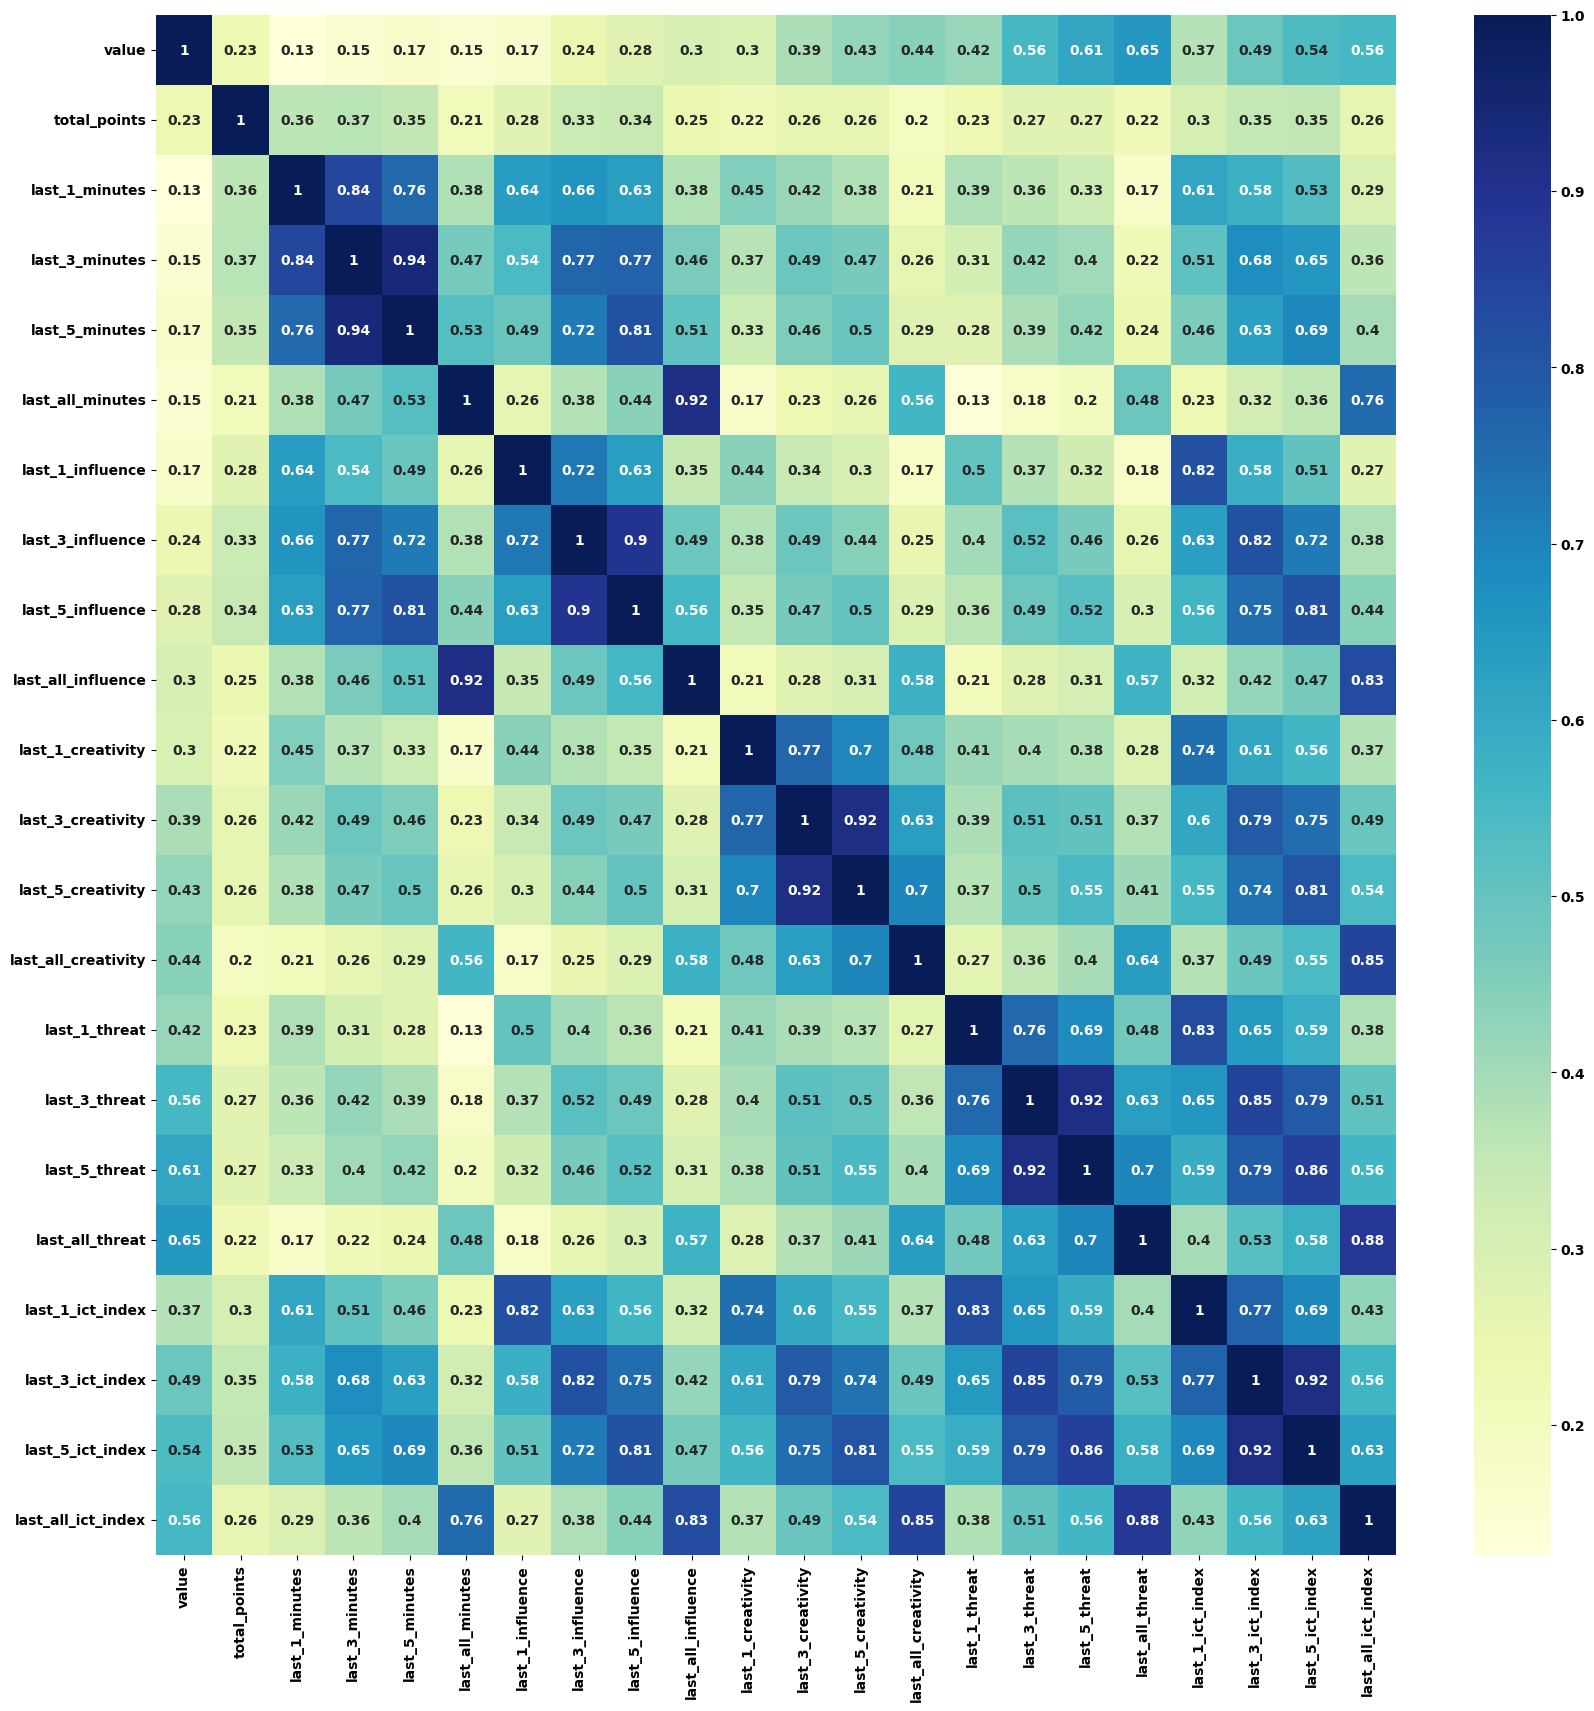

In [19]:
corr = all_season_lagged.iloc[:,4:].corr()

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.show()

It seems that the value of a player and change in cost follows their goal scoring threat from the previous 5 matches with a strong correlation of 0.64. Additionally, it seems that ict statistics in the previous 5 matches have a strong correlation with total_points with influence in last five having a correlation of 0.45, creativity with 0.35 and threat with 0.36.

We can also see the rotation bias with the high collinearity between minutes in previous match, previous 3 matches and previous 5 matches.

Additionally, the strong correlations in ict_statistics between the lagged window may introduce multicollinearity between the variables while also helping us to determine a consistent run of form.

It seems like the running sum of minutes, influence, creativity, threat and ict_index strongly relate to one another as well as a weak positive correlation of 0.21, 0.25, 0.2, 0.22, and 0.26 respectively.

<a id="m"><h1>Modelling</h1></a>

We will begin by encoding the positional data into binary form so that the model will be able to incorporate it. We will then split the data into train test split based on season number where the previous season 2022-23 will be our test data. We will then feed this data into multiple pipelines with different models for hyperparameter optimization through cross-validation results. We will split the data into seasonal cross-validation since the data is time-dependent based on gameweeks and seasons.
Once all the tuned models are outputted through the pipelines, we will compare all of the models to select the best one in terms of RMSE.

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

# Fit the OneHotEncoder to the positions column and transform
pos = pd.DataFrame(all_season_lagged['position'])
encoded = ohe.fit_transform(pos)

# Put into a dataframe to get column names
encoded_df = pd.DataFrame(encoded, columns=['DEF', 'FWD', 'GK', 'MID'], dtype=int)

# Add original back in
model_df = pd.concat([all_season_lagged, encoded_df], axis=1)

# Drop position and GK column
model_df = model_df.drop(['position', 'GK'], axis=1)

# Show
model_df.head()

,season_x,name,GW,value,total_points,last_1_minutes,last_3_minutes,last_5_minutes,last_all_minutes,last_1_influence,last_3_influence,last_5_influence,last_all_influence,last_1_creativity,last_3_creativity,last_5_creativity,last_all_creativity,last_1_threat,last_3_threat,last_5_threat,last_all_threat,last_1_ict_index,last_3_ict_index,last_5_ict_index,last_all_ict_index,DEF,FWD,MID
0,2016-17,Aaron Ramsey,6,77,0,0.0,0.000000,12.0,60,0.0,0.000000,0.44,2.2,0.0,0.000000,0.98,4.9,0.0,0.000000,4.6,23.0,0.0,0.000000,0.60,3.0,0,0,1
1,2016-17,Adam Forshaw,6,45,1,83.0,87.666667,84.4,422,8.8,10.200000,8.52,42.6,9.7,15.533333,12.74,63.7,0.0,6.666667,4.2,21.0,1.9,3.233333,2.54,12.7,0,0,1
2,2016-17,Adam Lallana,6,71,15,90.0,90.000000,84.4,422,12.0,21.800000,26.76,133.8,8.1,16.133333,22.40,112.0,10.0,19.666667,45.0,225.0,3.0,5.733333,9.40,47.0,0,0,1
3,2016-17,Adrián San Miguel del Castillo,6,50,3,90.0,90.000000,90.0,450,13.6,20.066667,23.72,118.6,0.0,0.000000,0.00,0.0,0.0,0.000000,0.0,0.0,1.4,2.000000,2.38,11.9,0,0,0
4,2016-17,Alex Iwobi,6,58,3,76.0,30.666667,30.0,150,51.0,18.266667,14.28,71.4,48.4,20.033333,15.52,77.6,95.0,31.666667,19.0,95.0,19.4,7.000000,4.88,24.4,0,0,1


In [21]:
# Train test split

X = model_df.drop('total_points', axis = 1)
y = model_df['total_points']

# splitting based on season 
X_train, X_test = X.loc[X['season_x'] <= '2021-22',], X.loc[X['season_x'] > '2021-22',]
y_train, y_test = y[:X_train.shape[0]], y[X_train.shape[0]:]

X_train = X_train.drop(['season_x', 'name', 'GW'], axis = 1)
X_test = X_test.drop(['season_x', 'name', 'GW'], axis = 1)

# Sanity check to make sure shapes of train and test sets are consistent
print(f"X_train Shape: {X_train.shape}\ny_train Shape:{y_train.shape}\n\nX_test Shape:{X_test.shape}\ny_test Shape:{y_test.shape}")

X_train Shape: (63298, 24)
y_train Shape:(63298,)

X_test Shape:(14340, 24)
y_test Shape:(14340,)


<a id="lr"><h2>Linear Regression</h2></a>

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from tempfile import mkdtemp
from sklearn import metrics

# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
tsc = TimeSeriesSplit(n_splits = 5)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearRegression())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [LinearRegression()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
#              'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
            }
]

# Cross Validation
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpco7gkyq_',
         steps=[('normalise', StandardScaler()), ('model', LinearRegression())])

<a id="lasso"><h2>Lasso Regression</h2></a>

In [23]:
# Cross-validation with time series split to split the folds by the number of gameweeks in the training set.
tsc = TimeSeriesSplit(n_splits = 5)

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', LinearRegression())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [Lasso()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
              'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10]
            }
]

# Cross Validation
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

C:\ProgramData\Anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.293e+04, tolerance: 9.992e+00
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.721e+01, tolerance: 1.928e+01
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\envs\capstone\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpfr2zs8y3',
         steps=[('normalise', StandardScaler()), ('model', Lasso(alpha=0.01))])

<a id="ridge"><h2>Ridge Regression</h2></a>

In [24]:
from sklearn.linear_model import Ridge

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', Ridge())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [Ridge()],
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__alpha': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
            }
]

# Cross Validation based on Time Series Split by number of GWs
grid = GridSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')

fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpjy09vyg8',
         steps=[('normalise', MinMaxScaler()), ('model', Ridge(alpha=60))])

<a id="rfr"><h2>Random Forest Regressor</h2></a>

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', RandomForestRegressor())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [RandomForestRegressor()], 
             'normalise': [StandardScaler(), MinMaxScaler(), None],
             'model__n_estimators': [i for i in range(25, 100, 25)],
             'model__max_depth': [i for i in range(2, 10, 2)],
             }
]

# Cross Validation based on Time Series Split by number of GWs
grid = RandomizedSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')
fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpd5n5t_n2',
         steps=[('normalise', StandardScaler()),
                ('model', RandomForestRegressor(max_depth=6, n_estimators=50))])

<a id="xgb"><h2>XGB Regressor</h2></a>

A brief explanation for the tuning of the hyperparameters

`max_depth`: larger values make the model more complex, more likely to overfit and take longer to train. I'll use the default range of 3-6 in attempt to reduce overfitting and complicating the model. Overfitting is likely to occur since the nature of the data can change drastically across seasons due to transfers, form/ability, and state of the club.

`min_child_weight`: Similar to max_depth, I will attempt to reduce the complexity/variance in the model. Larger values will reduce the likelihood of overfitting therefore, I will use a range from 6-10.

`learning_rate`: The default is 0.3. We will attempt to fit between: 1/10 of the default, 1/5 of the default, 1.5x the default, and 2x the default.

`subsample and colsample_by_tree`: The default is 1. To reduce overfitting we will use a range from 0.8 - 0.9.

In [26]:
from xgboost import XGBRegressor
# Save pipeline parameters in temperary directory
cachedir = mkdtemp()

# placeholders for pipeline
estimators = [('normalise', StandardScaler()),
              ('model', XGBRegressor())]

# Initializing pipeline
pipe = Pipeline(estimators, memory = cachedir)

# parameter grid for finding best model and hyperparameters for our data
param_grid = [
            {'model': [XGBRegressor()], 
             'normalise': [MinMaxScaler()],
             'model__max_depth': list(range(3,7)),
             'model__min_child_weight': list(range(6,11)),
             'model__learning_rate':  [0.03, 0.15, 0.3, 0.45, 0.6],
             'model__subsample': [0.8, 0.9, 1.0],
             'model__colsample_bytree': [0.8, 0.1]
             }
]

# Cross Validation based on Time Series Split by number of GWs
grid = RandomizedSearchCV(pipe, param_grid, cv=tsc, scoring = 'neg_root_mean_squared_error')
fittedgrid = grid.fit(X_train, y_train)
fittedgrid.best_estimator_

Pipeline(memory='C:\\Users\\FARHAN~1\\AppData\\Local\\Temp\\tmpwt4ep2ji',
         steps=[('normalise', MinMaxScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.15,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=9,
                              missing=nan, monotone_constraints=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, predictor=None,
                              random_state=None, ...))])

<a id="mc"><h1>Model Comparison</h1></a>

In [27]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Functions to get cross val scores and compare models

def get_cv_scores(models, X, y, k=tsc, seed=999):
    
    names = []
    results = []
    print("Cross val scores:")
    
    for name, scaler, m in models:
        if scaler == None:
            continue
        elif scaler == 'StandardScaler':
            scaler = StandardScaler()
            X = scaler.fit_transform(X)
        elif scaler == 'MinMax':
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X)
        cv_results = -cross_val_score(m, X, y, cv=k, scoring='neg_root_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        
        print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std() ))
        print("")
        print("*"*88)
        print("")
        
    return names, results

def compare_model_scores(model_names, model_results):
    
    fig = plt.figure()
    fig.suptitle('Model comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(model_results)
    ax.set_xticklabels(model_names)
    plt.show()

Cross val scores:
LinReg: 2.585029 (0.076599)

****************************************************************************************

Lasso: 2.583747 (0.074850)

****************************************************************************************

Ridge: 2.583154 (0.075292)

****************************************************************************************

RandomForest: 2.587540 (0.079291)

****************************************************************************************

XGB: 2.572441 (0.087709)

****************************************************************************************



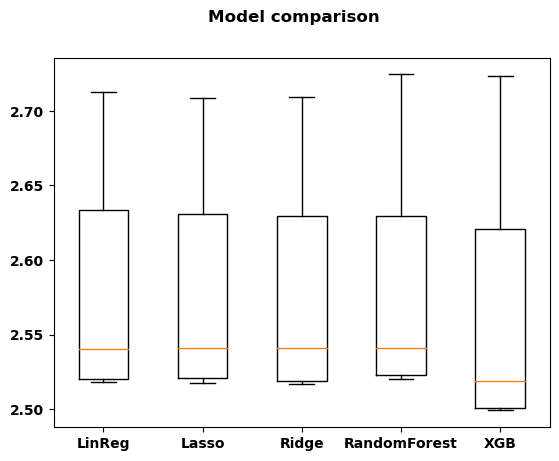

In [29]:
models = []

models.append(('LinReg', 'StandardScaler', LinearRegression()))
models.append(('Lasso', 'StandardScaler', Lasso(alpha=0.01)))
models.append(('Ridge', 'MinMax', Ridge(alpha=60)))
models.append(('RandomForest', 'None', RandomForestRegressor(max_depth=6, n_estimators=50)))
models.append(('XGB', 'MinMax', XGBRegressor(colsample_bytree=0.8,learning_rate=0.15,max_depth=3, min_child_weight=9)))

model_names, model_results = get_cv_scores(models, X_train, y_train)
compare_model_scores(model_names, model_results)